<h2>IMPORTS

In [1]:
import os
import glob

import numpy as np
print('numpy: %s' % np.__version__)
import pandas as pd
print('pandas: %s' % pd.__version__)
import pandas_bokeh

import matplotlib.pylab as plt
print('matplotlib: %s' % plt.__version__)
import seaborn as sns
import datetime
from datetime import date

import calendar
from calendar import monthrange
import holidays

from pandas_profiling import ProfileReport

%matplotlib inline

numpy: 1.19.2
pandas: 1.2.2
matplotlib: 1.19.2


<h2>Alle Dateien die im Ordner sind werden eingelesen und zum Dataframe hinzugefügt</h3>

In [2]:
list_df=[]
list_of_dates=[]
by_day_df = pd.DataFrame()


#get csv files and sort them
csv_files = glob.glob("*.csv")
csv_files.sort(key=os.path.getctime)

date_time_str = '2019-11-01 04:00:00'
date_time_start = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

date_time_str = '2019-11-01'
date_time_first = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_time_str = '2020-01-31'
date_time_end = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

date_list= pd.date_range(date_time_first , date_time_end, freq='D')


austria_holidays = holidays.CountryHoliday('AT', prov=1)

austria_holidays = austria_holidays['2019-11-01': '2020-11-01']

austria_holidays = date_list.isin(austria_holidays)

#Kapazität des Busmodells 15A - Mercedes Benz Citaro GNG 265 MB
kapaz = 129
    
for i, filename in enumerate (csv_files):
    
    #print(i, filename)
    
    #read the data and dont take the last column
    puffer_df= pd.read_csv(filename, index_col=None, header= 0,usecols=[0,1,2,3],decimal = ",", delimiter=";")

#     print(puffer_df)
    
    #DATUM
    
    for k in range (4,25):

        if k == 24 :
            #Zeit ist statt 24 am nächsten halt 23:59:59
            date_time_start = date_time_start.replace(hour = 23, minute = 59, second = 59)

        else:
            #datum ist nun um eine Stunde vorgestellt
            date_time_start = date_time_start.replace(hour = k)

        #HIER muss es zugewiesen werden bevor die stunde wieder verändert wird!!!!
        list_of_dates.append(date_time_start)
            
        
    puffer_df.insert(0,'Datum',list_of_dates)
    list_of_dates.clear()

    last_of_month = monthrange(date_time_start.year, date_time_start.month)[1]  

    if date_time_start.month != 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(month = date_time_start.month + 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    elif date_time_start.month == 12 and date_time_start.day == last_of_month:
        
        date_time_start = date_time_start.replace(year = date_time_start.year +1, month = 1, day = 1, hour = 4 , minute = 0, second = 0)
    
    else:
        date_time_start = date_time_start.replace(day = date_time_start.day + 1, hour = 4 , minute = 0, second = 0)
        
    #ENDE von DATUM
    
    
    puffer_df.insert(1,'Wochentag',calendar.day_name[date_list[i].weekday()])
    puffer_df.insert(6,'min_kapaz',puffer_df['Istfahrtenzahl']*kapaz)
    puffer_df.insert(7,'Feiertag',austria_holidays[i].astype(int))
    


    #vor dem Berechnen die NAN VALUES mit '0' ersetzen
    puffer_df.fillna(0, inplace = True)
    
    #stuff für die monats dataframe
    summe = puffer_df['P hochgerechnet'].sum()
    summesoll = puffer_df['Sollfahrtenzahl'].sum()
    summeist = puffer_df['Istfahrtenzahl'].sum()
    prozent = float(summeist/summesoll)*100
    kapaz_daily = summeist*kapaz
    
    

    row_month = {'datum': date_list[i], 'datum_tag': calendar.day_name[date_list[i].weekday()],
                 'eingänge_pro_tag': summe, 'fahrten_pro_tag_soll':summesoll, 'fahrten_pro_tag_ist':summeist,
                 'genauigkeit_pro_tag':prozent,'kapazität_täglich':kapaz_daily, 'tag=feiertag':austria_holidays[i].astype(int) }
    
    by_day_df = by_day_df.append(row_month , ignore_index = True)
    
    list_df.append(puffer_df) #!!!!
    
    by_hour_df = pd.concat(list_df, ignore_index = True)
    
    #print(puffer_df)
    #print(summe,summesoll,summeist,prozent)
    

In [3]:
by_day_df = by_day_df.reindex(columns=['datum','datum_tag','eingänge_pro_tag','fahrten_pro_tag_soll','fahrten_pro_tag_ist','genauigkeit_pro_tag','kapazität_täglich','tag=feiertag'])

In [ ]:
by_day_df.to_excel('daily_values.xlsx')
by_hour_df.to_excel('hourly_values.xlsx')

In [22]:
by_day_df.plot_knn_classification(n_neighbors=1)

AttributeError: 'DataFrame' object has no attribute 'plot_knn_classification'

In [4]:
by_day_df.head()

,datum,datum_tag,eingänge_pro_tag,fahrten_pro_tag_soll,fahrten_pro_tag_ist,genauigkeit_pro_tag,kapazität_täglich,tag=feiertag
0,2019-11-01,Friday,4936.608333,215.0,160.0,74.418605,20640.0,1.0
1,2019-11-02,Saturday,6379.658333,224.0,172.0,76.785714,22188.0,0.0
2,2019-11-03,Sunday,6260.500000,215.0,210.0,97.674419,27090.0,0.0
3,2019-11-04,Monday,11992.383532,317.0,275.0,86.750789,35475.0,0.0
4,2019-11-05,Tuesday,13416.813492,317.0,294.0,92.744479,37926.0,0.0


In [5]:
by_day_df.keys()

Index(['datum', 'datum_tag', 'eingänge_pro_tag', 'fahrten_pro_tag_soll',
       'fahrten_pro_tag_ist', 'genauigkeit_pro_tag', 'kapazität_täglich',
       'tag=feiertag'],
      dtype='object')

In [6]:
by_hour_df.head()

,Datum,Wochentag,Tageszeit,Sollfahrtenzahl,Istfahrtenzahl,P hochgerechnet,min_kapaz,Feiertag
0,2019-11-01 04:00:00,Friday,04:00 - 04:59,4,4,30.000000,516,1
1,2019-11-01 05:00:00,Friday,05:00 - 05:59,10,7,87.083333,903,1
2,2019-11-01 06:00:00,Friday,06:00 - 06:59,8,6,95.333333,774,1
3,2019-11-01 07:00:00,Friday,07:00 - 07:59,8,6,97.333333,774,1
4,2019-11-01 08:00:00,Friday,08:00 - 08:59,12,8,195.000000,1032,1


In [16]:
by_hour_df.keys()

Index(['Datum', 'Wochentag', 'Tageszeit', 'Sollfahrtenzahl', 'Istfahrtenzahl',
       'P hochgerechnet', 'Feiertag', 'min_kapaz'],
      dtype='object')

In [7]:
by_day_df.describe()

,eingänge_pro_tag,fahrten_pro_tag_soll,fahrten_pro_tag_ist,genauigkeit_pro_tag,kapazität_täglich,tag=feiertag
count,92.000000,92.000000,92.000000,92.000000,92.000000,92.000000
mean,18134.385775,280.728261,246.695652,87.930415,31823.739130,0.065217
std,6996.957012,46.663891,68.778948,19.055616,8872.484319,0.248262
min,4594.699567,215.000000,13.000000,4.100946,1677.000000,0.000000
25%,11176.834065,224.000000,209.000000,88.328076,26961.000000,0.000000
50%,21851.802537,312.000000,276.000000,96.529968,35604.000000,0.000000
75%,24091.964884,317.000000,306.250000,97.674419,39506.250000,0.000000
max,28617.187315,317.000000,317.000000,100.000000,40893.000000,1.000000


In [8]:
by_hour_df.describe()

,Sollfahrtenzahl,Istfahrtenzahl,P hochgerechnet,min_kapaz,Feiertag
count,1932.000000,1932.000000,1932.000000,1932.000000,1932.000000
mean,13.368012,11.747412,863.542180,1515.416149,0.065217
std,4.269734,4.932309,651.001529,636.267877,0.246973
min,4.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,8.000000,308.173199,1032.000000,0.000000
50%,13.000000,12.000000,756.525953,1548.000000,0.000000
75%,16.000000,16.000000,1308.095472,2064.000000,0.000000
max,23.000000,23.000000,3196.918908,2967.000000,1.000000


In [7]:
print("INFO")
print(by_day_df.info())
print(by_hour_df.info())

print("NULL VALUES?") 
print(by_day_df.isnull())
print(by_hour_df.isnull())

print("by_day")
print(np.where(pd.isnull(by_day_df)))
print("by_hour")
print(np.where(pd.isnull(by_hour_df)))

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datum                 92 non-null     datetime64[ns]
 1   datum_tag             92 non-null     object        
 2   eingänge_pro_tag      92 non-null     float64       
 3   fahrten_pro_tag_ist   92 non-null     float64       
 4   fahrten_pro_tag_soll  92 non-null     float64       
 5   genauigkeit_pro_tag   92 non-null     float64       
 6   kapazität_täglich     92 non-null     float64       
 7   tag=feiertag          92 non-null     float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 5.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932 entries, 0 to 1931
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Datum            193

In [9]:
##profile report für STUNDEN

report = ProfileReport(by_hour_df, title='Pandas Profiling Report')

report.to_widgets()

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
#profile report für TAGE

report = ProfileReport(by_day_df, title='Pandas Profiling Report')

report.to_widgets()

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
#interactive plotting in separate window
%matplotlib qt 

#%matplotlib inline

In [8]:
plt.close("all")

<h2>density plot

In [26]:
by_hour_df.plot(x="Datum", y="P hochgerechnet", kind= "kde")

<AxesSubplot:ylabel='Density'>

In [25]:
by_day_df.plot(x="datum", y="eingänge_pro_tag", kind= "kde")

<AxesSubplot:ylabel='Density'>

<h2>SPEICHERN DER GRAFIKEN

In [ ]:
num_posts_by_author_plot = by_hour_df.plot(x="Datum", y="P hochgerechnet", kind= "kde")


num_posts_by_author_plot.set_xlabel('Number of Posts on Marginal Revolution')

num_posts_by_author_plot.set_ylabel('Number of Posts on Marginal Revolution')

fig = num_posts_by_author_plot.get_figure()
fig.savefig('Grafiken-BA/num_posts_by_author_plot.png', bbox_inches="tight")

In [51]:
by_day_df.plot(x="datum", y="eingänge_pro_tag", kind= "kde")

<AxesSubplot:ylabel='Density'>

In [50]:
by_day_df["eingänge_pro_tag"].plot.kde() #erzeugt die gleiche Plot wie oben!

<AxesSubplot:ylabel='Density'>

<h2>Boxplot?

In [ ]:
by_hour_df.boxplot()

<h2>Zwei X Werte in einem Plot

In [17]:
by_hour_df.plot(x="Datum", y=["P hochgerechnet", "min_kapaz"], kind= "line")

<AxesSubplot:xlabel='Datum'>

In [18]:
by_day_df.plot(x="datum", y=["eingänge_pro_tag", "kapazität_täglich"], kind= "line")

<AxesSubplot:xlabel='datum'>

<h2>Zwei Werte in einem Plot, aber mit mehr Customizing

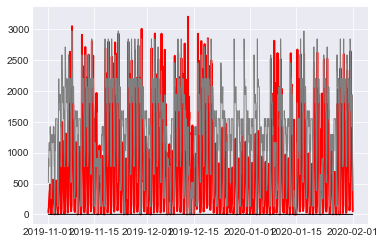

In [60]:
plt.style.use('seaborn-darkgrid')

plt.plot("Datum","P hochgerechnet",color="red", data = by_hour_df,linewidth=2)
plt.plot("Datum","min_kapaz", data = by_hour_df,color="grey", linewidth=1)
plt.plot("Datum","Feiertag", data = by_hour_df,color="black", linewidth=1)




<h2>Lollipop plot, histogram macht da mehr sinn

In [29]:
my_range=range(1,len(by_hour_df.index)+1)

plt.hlines(y=my_range, xmin=0, xmax=by_hour_df['P hochgerechnet'], color='skyblue')
plt.plot(by_hour_df['P hochgerechnet'], my_range, "o")


<h2> SUBPLOT; ALLE PLOTS

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

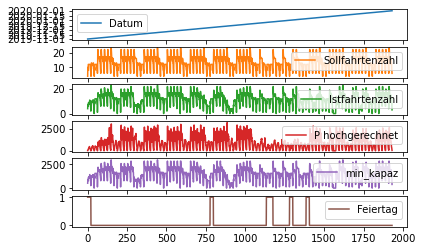

In [11]:
#plt.style.use('seaborn-darkgrid')

by_hour_df.plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

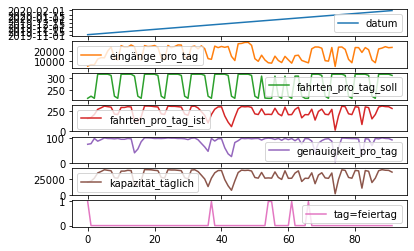

In [12]:
by_day_df.plot(subplots=True)

<h2>Seaborn Histogram plots, sind schöner

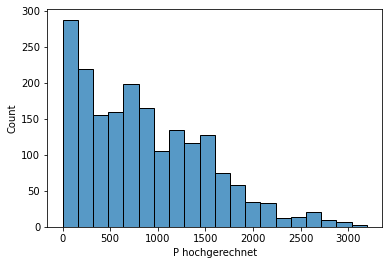

In [13]:
sns.histplot(by_hour_df["P hochgerechnet"])
plt.show()

#das gleiche nur anders
# sns.displot(by_hour_df["P hochgerechnet"])
# plt.show()

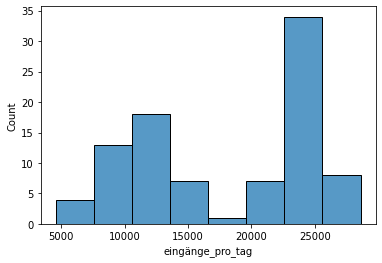

In [14]:
sns.histplot(by_day_df["eingänge_pro_tag"])
plt.show()

# sns.displot(by_day_df["eingänge_pro_tag"])
# plt.show()

<h2> normale histogram

In [32]:
by_hour_df.hist(color="k", alpha=0.5, bins=50);

<h2> Lag Plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

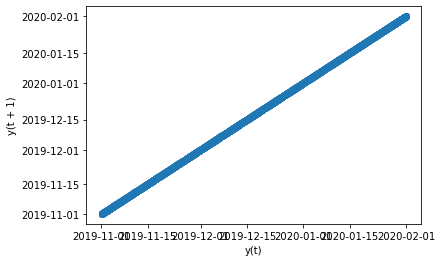

In [11]:
from pandas.plotting import lag_plot

plt.figure()

lag_plot(by_hour_df["Datum"])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

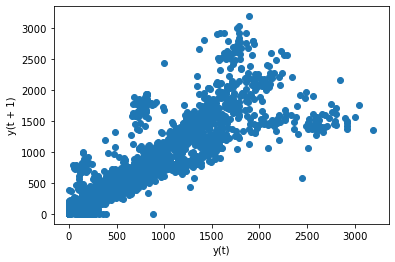

In [12]:
from pandas.plotting import lag_plot

plt.figure()

lag_plot(by_hour_df["P hochgerechnet"])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

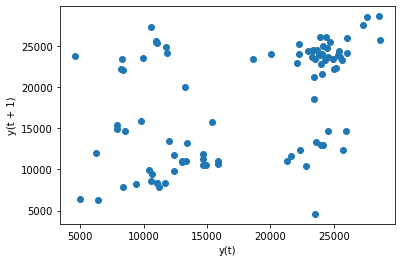

In [14]:
from pandas.plotting import lag_plot

plt.figure()

lag_plot(by_day_df["eingänge_pro_tag"])

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

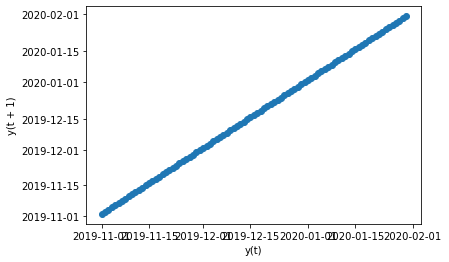

In [13]:
from pandas.plotting import lag_plot

plt.figure()

lag_plot(by_day_df["datum"])

<h2>Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

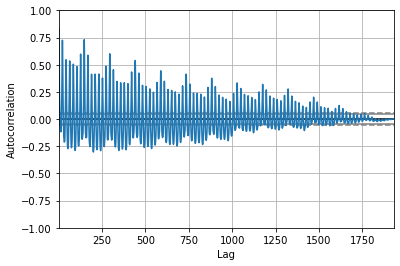

In [15]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(by_hour_df["P hochgerechnet"])

In [ ]:
# inter = by_hour_df[1558:1575]
# print(inter)
# inter.is_copy = None
# inter.interpolate(inplace= True)
# #inter = inter["P hochgerechnet"]
# print(inter)


# print(inter)

<h2> Normale Plots

In [10]:
by_day_df.plot(x= "datum", y="eingänge_pro_tag", kind="scatter")

plt.tight_layout()
plt.show()

In [11]:
by_hour_df.plot(x= "Datum", y="P hochgerechnet", kind="scatter")


<AxesSubplot:xlabel='Datum', ylabel='P hochgerechnet'>

In [15]:
by_hour_df.plot(x="Datum", y="P hochgerechnet", kind="line")

plt.tight_layout()
plt.show()

In [14]:
#das gleiche wie oben nur xlabel ist tageszeit und nicht so übersichtlich
by_hour_df.plot(x="Tageszeit", y="P hochgerechnet", kind="line")
plt.show()

In [45]:
pandas_bokeh.output_notebook()

#pandas_bokeh.output_file('chart.html')

#kind what type of chart do you want to plot? Currently, pandas_bokeh supports the following chart types: line, point, step, scatter, bar, histogram, area, pie and map.

Loading BokehJS ...

In [72]:
by_hour_df.plot_bokeh(
    kind='line',
    x='Datum',
    y='P hochgerechnet',
    #figsize=(2000, 1000),
    #ylim=(0, 2000),
    xlabel='Datum',
    ylabel='Passagier Einstiege',
    title='Einstiege nach Datum'
)

Figure(id='12455', ...)

In [25]:
# reduce data size to one week
week = by_hour_df.loc['2019-11-01':'2019-11-30']

week.head()

,Datum,Wochentag,Tageszeit,Sollfahrtenzahl,Istfahrtenzahl,P hochgerechnet,Feiertag,min_kapaz


In [ ]:
for index,row in by_day_df.iterrows():
    print(index,row)
    #plt.bar(row.keys(),row.values)
    #plt.savefig('./plots/chart_' + index)